In [19]:
# load necessary libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

In [3]:
def relay_feedback(d, error):
    """Relay-feedback control
    The control outputs d if error higher than 0, outputs -d if error lower than 0, outputs 0 if error 0.
    
    args:
    - d (int or float) = relay output amplitude
    - error (int or float) = the difference between reference and feedback
    
    return:
    u (float) = controller output
    """
    if error > 0:
        u = d
    elif error < 0:
        u = -d
    else:
        u = 0
    
    return u

In [65]:
def PID(Kp=1, Ti=1, Td=1, t_initial=0, u_bar=0, control_type='pid'):
    """Basic PID controller
    
    args:
    - Kp (int or float) default: 1 = proportional gain
    - Ti (int or float) default: 1 = integral period
    - Td (int or float) default: 1 = derivative period
    - t_initial (int or float) default: 0 = initial time
    - u_bar (int or float) default: 0 = base line for control signal
    - control_type (str) default: 'pid' = choose control type, i.e. either 'p' (proportional only), 'pi' (proportional and integral), 'pd' (proportional and derivative), or 'pid' (full PID)

    yield:
    - u (float) = control signal

    generator send():
    - t, feedback, ref (list-like type) = time, feedback (output from model), and reference
    """
    if not(control_type == 'p' or control_type == 'pi' or control_type == 'pd' or control_type == 'pid'):
        raise ValueError("'control_type' arg only accepts either 'p', 'pi', 'pd', or 'pid'")

    # initialize stored data
    e_prev = 0
    t_prev = t_initial #-100
    I = 0
    
    # initial control
    u = u_bar

    while True:
        # yield MV, wait for new t, PV, SP
        t, feedback, ref = yield u
        
        # PID calculations
        e = ref - feedback
        de = e - e_prev
        dt = t - t_prev

        P = Kp*e
        I = I + e*dt
        D = de/dt
        
        if control_type == 'p':
            u = u_bar + P
        elif control_type == 'pi':
            u = u_bar + Kp*(e + (1/Ti)*I)
        elif control_type == 'pd':
            u = u_bar + Kp*(e + Td*D)
        else:
            u = u_bar + Kp*(e + (1/Ti)*I + Td*D)
        
        # update stored data for next iteration
        e_prev = e
        t_prev = t

In [4]:
def car_dynamics(b, v_in, u, m, dt):
    """Vehicle dynamics model
    
    args:
    - b (int or float) = friction constant (Nm/s)
    - v_in (int or float) = input/initial speed (m/s)
    - u (int or float) = control signal (N)
    - m (int or float) = vehicle mass (kg)
    - dt (int or float) = difference of time (s)

    return:
    v_out (float) = output/final speed (m/s)
    """
    temp = (-b*v_in + u)/m
    v_out = temp*dt + v_in
    return v_out

In [118]:
# define constants
d = 80
mass = 1000 #kg
frict = 50 #Nm/s

# set speed reference
ref = np.ones(shape=200)

# define useful array variables
feedback = np.zeros(shape=ref.shape)
times = np.arange(start=1, stop=len(ref), step=1)
u = np.zeros(shape=ref.shape)
error = np.zeros(shape=ref.shape)

t_prev = 0 # buffer to store previous time

# loop through each time t
for t in tqdm(times):
    error[t] = ref[t-1] - feedback[t-1] # get error at time t
    u[t] = relay_feedback(d, error[t]) #controller.send([t, feedback[t-1], ref[t-1]]) # calculate PID
    feedback[t] = car_dynamics(b=frict, v_in=feedback[t-1], u=u[t], m=mass, dt=t-t_prev) # calculate model output
    t_prev = t # store for next iteration

100%|████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 110070.75it/s]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'Error of speed (m/s)')

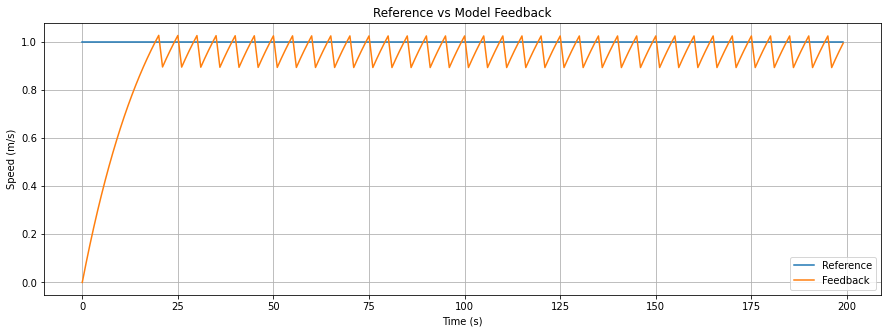

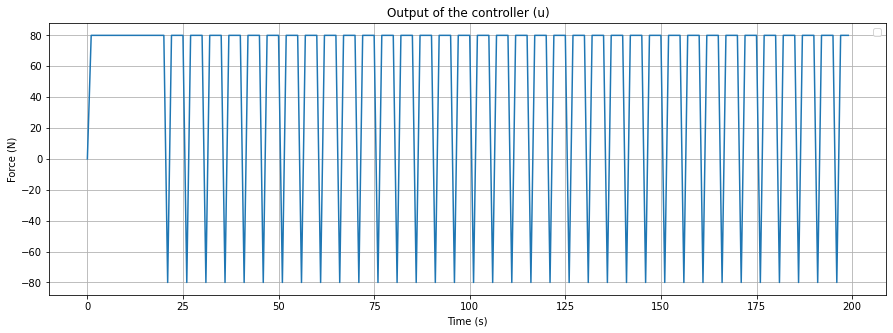

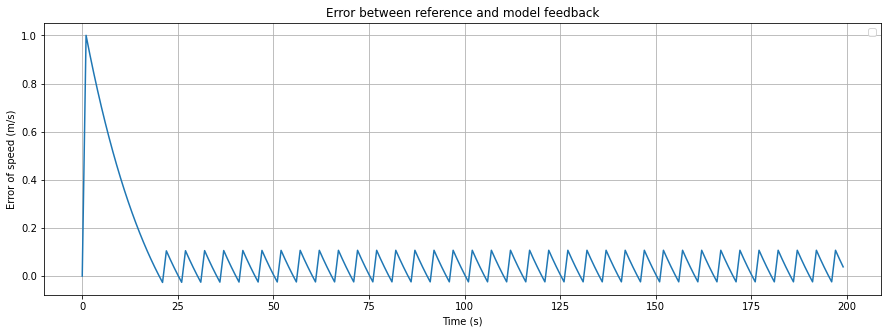

In [119]:
# plot reference vs feedback
plt.figure(figsize=(15,5))
line1, = plt.plot([0] + times.tolist(), ref)
line2, = plt.plot([0] + times.tolist(), feedback)
plt.legend([line1, line2], ['Reference', 'Feedback'])
plt.grid()
plt.title("Reference vs Model Feedback")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")

# plot u
plt.figure(figsize=(15,5))
plt.plot([0] + times.tolist(), u)
plt.legend()
plt.grid()
plt.title("Output of the controller (u)")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")

# plot error
plt.figure(figsize=(15,5))
plt.plot([0] + times.tolist(), error)
plt.legend()
plt.grid()
plt.title("Error between reference and model feedback")
plt.xlabel("Time (s)")
plt.ylabel("Error of speed (m/s)")

In [120]:
# find peaks in feedback signal
peaks, _ = find_peaks(feedback) # get idx of peaks
print('peaks:', feedback[peaks])

peaks: [1.02642252 1.02585568 1.02541707 1.02507768 1.02481507 1.02461187
 1.02445463 1.02433296 1.02423882 1.02416598 1.02410961 1.02406599
 1.02403224 1.02400613 1.02398592 1.02397029 1.02395819 1.02394883
 1.02394158 1.02393598 1.02393164 1.02392829 1.02392569 1.02392368
 1.02392212 1.02392092 1.02391999 1.02391927 1.02391871 1.02391828
 1.02391795 1.02391769 1.02391749 1.02391734 1.02391722 1.02391712]


In [121]:
# find valleys in feedback signal
inv_feedback = feedback*(-1)
valleys, _ = find_peaks(inv_feedback) # get idx of valleys
print('valleys:', feedback[valleys])

valleys: [0.8951014  0.8945629  0.89414622 0.8938238  0.89357432 0.89338127
 0.8932319  0.89311632 0.89302688 0.89295768 0.89290413 0.89286269
 0.89283063 0.89280582 0.89278663 0.89277177 0.89276028 0.89275139
 0.8927445  0.89273918 0.89273506 0.89273187 0.8927294  0.8927275
 0.89272602 0.89272488 0.89272399 0.89272331 0.89272278 0.89272237
 0.89272205 0.89272181 0.89272162 0.89272147 0.89272135 0.89272127]


In [134]:
amp_type1 = (np.mean(feedback[peaks]) - np.mean(feedback[valleys]))/2
print('amplitude type 1:', amp_type1)

amplitude type 1: 0.06560561142671362


In [135]:
amp_type2 = np.mean((feedback[peaks] - feedback[valleys])/2)
print('amplitude type 2:', amp_type2)

amplitude type 2: 0.06560561142671359


In [136]:
amp = np.mean([amp_type1, amp_type2])
print('amplitude final:', amp)

amplitude final: 0.0656056114267136


In [137]:
# calculate Ku
Ku = (4*d)/(np.pi*amp)
print('Ku =', Ku)

Ku = 1552.5983427895853


In [141]:
# np.mean(np.diff))
Tu = np.mean(np.diff(peaks))
Tu

5.0

In [129]:
N = peaks.shape[0] - 1
T_total = times[-1] + 1
freq = N*(1/T_total)

In [130]:
Tu = 1/freq
print('Tu =', Tu)

Tu = 5.7142857142857135


In [139]:
##################################################
#### STEP 2: GET Ku & Tu AND CALCULATE Kp, Ti, Td ####

# calculate Kp, Ti, Td using different control type
pid_control_type = {'p': [0.5*Ku, 0, 0],
                    'pi': [0.45*Ku, 0.8*Tu, 0],
                    'pd': [0.8*Ku, 0, 0.125*Tu],
                    'classic_pid': [0.6*Ku, 0.5*Tu, 0.125*Tu],
                    'pessen_integral_rule': [0.7*Ku, 0.4*Tu, 0.15*Tu],
                    'some_overshoot': [0.33*Ku, 0.5*Tu, 0.33*Tu],
                    'no_overshoot': [0.2*Ku, 0.5*Tu, 0.33*Tu]}

for key, value in pid_control_type.items():
    print(f"Control type '{key}':")
    print(f"Kp = {value[0] if value[0] != 0 else '_'}")
    print(f"Ti = {value[1] if value[1] != 0 else '_'}")
    print(f"Td = {value[2] if value[2] != 0 else '_'}")
    print('\n')

##################################################
#### STEP 3: RUN ALL CONTROLLER TYPES USING CONSTANTS JUST OBTAINED ####

# buffer
ref_list = []
feedback_list = []
MSE_list = []
MAE_list = []
RMSE_list = []

# loop each control_type
for key, value in pid_control_type.items():
    # get constants
    Kp = value[0]
    Ti = value[1]
    Td = value[2]

    # set control_type arg for PID function
    if key == 'p' or key == 'pi' or key == 'pd':
        control_type = key
    else:
        control_type = 'pid'

    print('==================================================')
    print(f"Control type: {key}")
    print('==================================================')

    # declare PID controller
    controller = PID(Kp=Kp, Ti=Ti, Td=Td, control_type=control_type)
    controller.send(None) # initialize controller

    # set speed reference
    ref = np.concatenate((np.ones(shape=50) * 2, np.ones(shape=50) * 10))

    # define useful array variables
    feedback = np.zeros(shape=ref.shape)
    times = np.arange(start=1, stop=len(ref), step=1)
    u = np.zeros(shape=ref.shape)
    error = np.zeros(shape=ref.shape)

    t_prev = 0 # buffer to store previous time

    # loop through each time t
    for t in times:
        error[t] = ref[t-1] - feedback[t-1] # get error at time t
        u[t] = controller.send([t, feedback[t-1], ref[t-1]]) # calculate PID
        feedback[t] = car_dynamics(b=frict, v_in=feedback[t-1], u=u[t], m=mass, dt=t-t_prev) # calculate model output
        t_prev = t # store for next iteration

    # store ref and feedback
    ref_list.append(ref)
    feedback_list.append(feedback)

    # MSE
    mse = np.mean(np.square(error))
    print(f"Mean squared error: {round(mse, 3)}")
    MSE_list.append(mse)

    # MAE
    mae = np.mean(np.absolute(error))
    print(f"Mean absolute error: {round(mae, 3)}")
    MAE_list.append(mae)

    # RMSE
    rmse = np.sqrt(np.mean(np.square(error)))
    print(f"Root mean square error: {round(rmse, 3)}")
    RMSE_list.append(rmse)

Control type 'p':
Kp = 776.2991713947927
Ti = _
Td = _


Control type 'pi':
Kp = 698.6692542553134
Ti = 4.0
Td = _


Control type 'pd':
Kp = 1242.0786742316684
Ti = _
Td = 0.625


Control type 'classic_pid':
Kp = 931.5590056737511
Ti = 2.5
Td = 0.625


Control type 'pessen_integral_rule':
Kp = 1086.8188399527096
Ti = 2.0
Td = 0.75


Control type 'some_overshoot':
Kp = 512.3574531205632
Ti = 2.5
Td = 1.6500000000000001


Control type 'no_overshoot':
Kp = 310.5196685579171
Ti = 2.5
Td = 1.6500000000000001


Control type: p
Mean squared error: 0.921
Mean absolute error: 0.471
Root mean square error: 0.96
Control type: pi
Mean squared error: 0.748
Mean absolute error: 0.197
Root mean square error: 0.865
Control type: pd
Mean squared error: 4.725359575490303e+36
Mean absolute error: 4.633081224508878e+17
Root mean square error: 2.1737892205755146e+18
Control type: classic_pid
Mean squared error: 1.2520210550006264e+17
Mean absolute error: 108162436.38
Root mean square error: 353839095.494
C

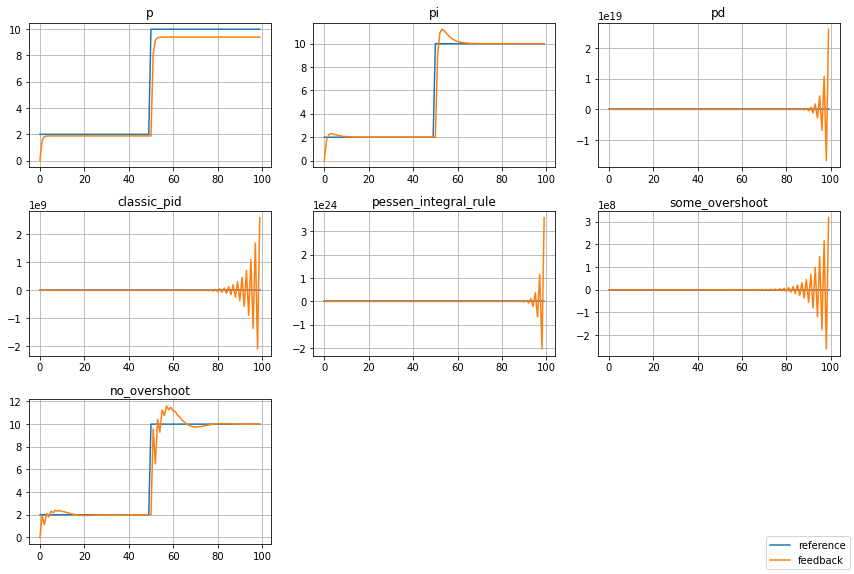

In [140]:
# plot all 7 controllers
fig, axs = plt.subplots(3, 3, figsize=(12,8))
axs[0,0].plot([0] + times.tolist(), ref_list[0])
axs[0,0].plot([0] + times.tolist(), feedback_list[0])
axs[0,0].set_title(list(pid_control_type.keys())[0])
axs[0,0].grid()

axs[0,1].plot([0] + times.tolist(), ref_list[1])
axs[0,1].plot([0] + times.tolist(), feedback_list[1])
axs[0,1].set_title(list(pid_control_type.keys())[1])
axs[0,1].grid()

axs[0,2].plot([0] + times.tolist(), ref_list[2])
axs[0,2].plot([0] + times.tolist(), feedback_list[2])
axs[0,2].set_title(list(pid_control_type.keys())[2])
axs[0,2].grid()

axs[1,0].plot([0] + times.tolist(), ref_list[3])
axs[1,0].plot([0] + times.tolist(), feedback_list[3])
axs[1,0].set_title(list(pid_control_type.keys())[3])
axs[1,0].grid()

axs[1,1].plot([0] + times.tolist(), ref_list[4])
axs[1,1].plot([0] + times.tolist(), feedback_list[4])
axs[1,1].set_title(list(pid_control_type.keys())[4])
axs[1,1].grid()

axs[1,2].plot([0] + times.tolist(), ref_list[5])
axs[1,2].plot([0] + times.tolist(), feedback_list[5])
axs[1,2].set_title(list(pid_control_type.keys())[5])
axs[1,2].grid()

line1, = axs[2,0].plot([0] + times.tolist(), ref_list[6])
line2, = axs[2,0].plot([0] + times.tolist(), feedback_list[6])
axs[2,0].set_title(list(pid_control_type.keys())[6])
axs[2,0].grid()

fig.delaxes(axs[2,1])
fig.delaxes(axs[2,2])

fig.legend((line1, line2), ('reference', 'feedback'), loc='lower right')

fig.tight_layout()

In [108]:
# create dataframe for MSE, MAE, RMSE
df = pd.DataFrame([list(pid_control_type.keys()), MSE_list, MAE_list, RMSE_list])
df = df.transpose()
df.columns = ['control_type', 'MSE', 'MAE', 'RMSE']

In [109]:
df

,control_type,MSE,MAE,RMSE
0,p,0.921191,0.470712,0.959787
1,pi,0.742318,0.196984,0.861579
2,pd,5.6247e+43,1.47224e+21,7.4998e+21
3,classic_pid,1.39296e+23,9.88439e+10,3.73224e+11
4,pessen_integral_rule,1.22527e+52,2.00626e+25,1.10692e+26
5,some_overshoot,1.01519e+24,2.61674e+11,1.00757e+12
6,no_overshoot,1.03845,0.342615,1.01905
